# 1. Load Modules


In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline
import sklearn
import seaborn as sns

# 2. Import Data: tds == TDS == gv_FILE_OUT_TDS

In [2]:
TDS = pd.read_csv("C:/Users/stc/Documents/notebooks/Verkaufsprognose Modeling/TDS.csv", low_memory=False, sep=';')

In [3]:
TDS.describe()

,ENDKUNDE_NR,AJ,AJ_01,AJ_03,AJ_05,AJ_07,AJ_09,AJ_11,AJ_13,AJ_15,...,VVVJ_KONTAKT_L2_KW33,VVVJ_KONTAKT_L2_KW35,VVVJ_KONTAKT_L2_KW37,VVVJ_KONTAKT_L2_KW39,VVVJ_KONTAKT_L2_KW41,VVVJ_KONTAKT_L2_KW43,VVVJ_KONTAKT_L2_KW45,VVVJ_KONTAKT_L2_KW47,VVVJ_KONTAKT_L2_KW49,VVVJ_KONTAKT_L2_KW51
count,39215.000000,39215.000000,2.289300e+04,22893.000000,22893.000000,2.289300e+04,2.289300e+04,2.289300e+04,2.289300e+04,2.289300e+04,...,20858.000000,20858.000000,20858.000000,20858.000000,20858.000000,20858.000000,20858.000000,20858.000000,20858.000000,20858.000000
mean,470178.383297,2017.648553,1.072982e+03,1221.907002,1531.508409,1.936007e+03,1.780914e+03,1.808229e+03,2.403786e+03,2.451937e+03,...,0.028239,0.027663,0.026848,0.031882,0.033800,0.032649,0.031738,0.029821,0.029054,0.026129
std,195650.696262,1.187913,1.612678e+04,15427.668264,17920.347896,3.108543e+04,2.132737e+04,3.276476e+04,4.473486e+04,2.932961e+04,...,0.165658,0.164010,0.161644,0.175691,0.180718,0.177721,0.175307,0.170096,0.167961,0.159523
min,100034.000000,2015.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,445080.000000,2017.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,564263.000000,2018.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,614083.500000,2019.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,657233.000000,2019.000000,1.245157e+06,971153.000000,904361.000000,2.011256e+06,1.423671e+06,3.430133e+06,4.189469e+06,2.774594e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
TDS.head(5)
#DS.info()

,ENDKUNDE_NR,AJ,AJ_01,AJ_03,AJ_05,AJ_07,AJ_09,AJ_11,AJ_13,AJ_15,...,VVVJ_KONTAKT_L2_KW33,VVVJ_KONTAKT_L2_KW35,VVVJ_KONTAKT_L2_KW37,VVVJ_KONTAKT_L2_KW39,VVVJ_KONTAKT_L2_KW41,VVVJ_KONTAKT_L2_KW43,VVVJ_KONTAKT_L2_KW45,VVVJ_KONTAKT_L2_KW47,VVVJ_KONTAKT_L2_KW49,VVVJ_KONTAKT_L2_KW51
0,100034,2016,0.0,20909.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
1,100034,2017,0.0,0.0,7897.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100034,2018,0.0,0.0,3963.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,100034,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,100039,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Data Preparation

## 3.1 Data Selection

Originale erhalten für Vorhersage

In [5]:
gv_AJAW_KW = 29 # aktuelle Kalenderwoche, basierend auf gv_AJAW = Datum an dem das Script lief, 15.07.2019

In [6]:
feature_columns   = [] # Features/Merkmale
predictor_columns = [] # Predictores/Targets
leftover_columns  = [] # Leftover
for col_name in TDS.keys():
    if (col_name.startswith("VJ")  | # Umsatz Vorjahr
        col_name.startswith("VVJ") |
        col_name.startswith("VVVJ")|
        col_name.startswith("B")   ):
        feature_columns.append(col_name)
    elif (col_name.startswith("AJ_") and len(col_name) < 6)  :
        predictor_columns.append(col_name)
    else:
        leftover_columns.append(col_name)

    

Exclude ``VJ_KONTAKT_L1_KW29``:

In [7]:
feature_columns.remove("VJ_KONTAKT_L1_KW29") # it's removed in the R-Markdown script
#feature_columns.remove("VJNet")
feature_columns.sort()

## 3.2 Data Check

In [8]:
df_describe = TDS.loc[:,feature_columns+["AJ_29"]]
df_describe["target"] = TDS["AJ_29"].map(lambda x: int(bool(abs(x))))

In [9]:
def desc_tool(df_x):
    pd.options.display.max_columns = None
    display(df_x.describe())
    #print("\ndf_x.info():",df_x.info())
    print("\nDataset Shape:",df_x.shape)

In [10]:
desc_tool(df_describe)

,B105,B110,B115,B116,B120,B125,B130,B135,B140,B145,B150,B155,B160,B165,B170,B185,B195,B225,B230,B240,B241,B290,B295,B325,B330,B332,B334,B339,B349,B350,B351,B352,B353,B354,B356,B357,B366,B367,B371,B390,B400,B401,B405,B410,B420,B425,B435,B436,B445,B446,B447,B448,B455,B460,B464,B465,B466,B468,B469,B470,B475,B503,B504,B508,B509,B535,B555,B556,B575,B610,B695,B705,B720,B765,B780,B795,B800,B901,B950,B960,B970,B980,B990,VJNet,VJ_01,VJ_03,VJ_05,VJ_07,VJ_09,VJ_11,VJ_13,VJ_15,VJ_17,VJ_19,VJ_21,VJ_23,VJ_25,VJ_27,VJ_29,VJ_31,VJ_33,VJ_35,VJ_37,VJ_39,VJ_41,VJ_43,VJ_45,VJ_47,VJ_49,VJ_51,VJ_KONTAKT_L1_KW01,VJ_KONTAKT_L1_KW03,VJ_KONTAKT_L1_KW05,VJ_KONTAKT_L1_KW07,VJ_KONTAKT_L1_KW09,VJ_KONTAKT_L1_KW11,VJ_KONTAKT_L1_KW13,VJ_KONTAKT_L1_KW15,VJ_KONTAKT_L1_KW17,VJ_KONTAKT_L1_KW19,VJ_KONTAKT_L1_KW21,VJ_KONTAKT_L1_KW23,VJ_KONTAKT_L1_KW25,VJ_KONTAKT_L1_KW27,VJ_KONTAKT_L1_KW31,VJ_KONTAKT_L1_KW33,VJ_KONTAKT_L1_KW35,VJ_KONTAKT_L1_KW37,VJ_KONTAKT_L1_KW39,VJ_KONTAKT_L1_KW41,VJ_KONTAKT_L1_KW43,VJ_KONTAKT_L1_KW45,VJ_KONTAKT_L1_KW47,VJ_KONTAKT_L1_KW49,VJ_KONTAKT_L1_KW51,VJ_KONTAKT_L2_KW01,VJ_KONTAKT_L2_KW03,VJ_KONTAKT_L2_KW05,VJ_KONTAKT_L2_KW07,VJ_KONTAKT_L2_KW09,VJ_KONTAKT_L2_KW11,VJ_KONTAKT_L2_KW13,VJ_KONTAKT_L2_KW15,VJ_KONTAKT_L2_KW17,VJ_KONTAKT_L2_KW19,VJ_KONTAKT_L2_KW21,VJ_KONTAKT_L2_KW23,VJ_KONTAKT_L2_KW25,VJ_KONTAKT_L2_KW27,VJ_KONTAKT_L2_KW29,VJ_KONTAKT_L2_KW31,VJ_KONTAKT_L2_KW33,VJ_KONTAKT_L2_KW35,VJ_KONTAKT_L2_KW37,VJ_KONTAKT_L2_KW39,VJ_KONTAKT_L2_KW41,VJ_KONTAKT_L2_KW43,VJ_KONTAKT_L2_KW45,VJ_KONTAKT_L2_KW47,VJ_KONTAKT_L2_KW49,VJ_KONTAKT_L2_KW51,VJ_NETKAT_01,VJ_NETKAT_02,VJ_NETKAT_03,VJ_NETKAT_04,VJ_NETKAT_05,VJ_NETKAT_06,VJ_NETKAT_07,VJ_NETKAT_08,VJ_NETKAT_09,VJ_NETKAT_10,VVJNet,VVJ_01,VVJ_03,VVJ_05,VVJ_07,VVJ_09,VVJ_11,VVJ_13,VVJ_15,VVJ_17,VVJ_19,VVJ_21,VVJ_23,VVJ_25,VVJ_27,VVJ_29,VVJ_31,VVJ_33,VVJ_35,VVJ_37,VVJ_39,VVJ_41,VVJ_43,VVJ_45,VVJ_47,VVJ_49,VVJ_51,VVJ_KONTAKT_L1_KW01,VVJ_KONTAKT_L1_KW03,VVJ_KONTAKT_L1_KW05,VVJ_KONTAKT_L1_KW07,VVJ_KONTAKT_L1_KW09,VVJ_KONTAKT_L1_KW11,VVJ_KONTAKT_L1_KW13,VVJ_KONTAKT_L1_KW15,VVJ_KONTAKT_L1_KW17,VVJ_KONTAKT_L1_KW19,VVJ_KONTAKT_L1_KW21,VVJ_KONTAKT_L1_KW23,VVJ_KONTAKT_L1_KW25,VVJ_KONTAKT_L1_KW27,VVJ_KONTAKT_L1_KW29,VVJ_KONTAKT_L1_KW31,VVJ_KONTAKT_L1_KW33,VVJ_KONTAKT_L1_KW35,VVJ_KONTAKT_L1_KW37,VVJ_KONTAKT_L1_KW39,VVJ_KONTAKT_L1_KW41,VVJ_KONTAKT_L1_KW43,VVJ_KONTAKT_L1_KW45,VVJ_KONTAKT_L1_KW47,VVJ_KONTAKT_L1_KW49,VVJ_KONTAKT_L1_KW51,VVJ_KONTAKT_L2_KW01,VVJ_KONTAKT_L2_KW03,VVJ_KONTAKT_L2_KW05,VVJ_KONTAKT_L2_KW07,VVJ_KONTAKT_L2_KW09,VVJ_KONTAKT_L2_KW11,VVJ_KONTAKT_L2_KW13,VVJ_KONTAKT_L2_KW15,VVJ_KONTAKT_L2_KW17,VVJ_KONTAKT_L2_KW19,VVJ_KONTAKT_L2_KW21,VVJ_KONTAKT_L2_KW23,VVJ_KONTAKT_L2_KW25,VVJ_KONTAKT_L2_KW27,VVJ_KONTAKT_L2_KW29,VVJ_KONTAKT_L2_KW31,VVJ_KONTAKT_L2_KW33,VVJ_KONTAKT_L2_KW35,VVJ_KONTAKT_L2_KW37,VVJ_KONTAKT_L2_KW39,VVJ_KONTAKT_L2_KW41,VVJ_KONTAKT_L2_KW43,VVJ_KONTAKT_L2_KW45,VVJ_KONTAKT_L2_KW47,VVJ_KONTAKT_L2_KW49,VVJ_KONTAKT_L2_KW51,VVJ_NETKAT_01,VVJ_NETKAT_02,VVJ_NETKAT_03,VVJ_NETKAT_04,VVJ_NETKAT_05,VVJ_NETKAT_06,VVJ_NETKAT_07,VVJ_NETKAT_08,VVJ_NETKAT_09,VVJ_NETKAT_10,VVVJNet,VVVJ_01,VVVJ_03,VVVJ_05,VVVJ_07,VVVJ_09,VVVJ_11,VVVJ_13,VVVJ_15,VVVJ_17,VVVJ_19,VVVJ_21,VVVJ_23,VVVJ_25,VVVJ_27,VVVJ_29,VVVJ_31,VVVJ_33,VVVJ_35,VVVJ_37,VVVJ_39,VVVJ_41,VVVJ_43,VVVJ_45,VVVJ_47,VVVJ_49,VVVJ_51,VVVJ_KONTAKT_L1_KW01,VVVJ_KONTAKT_L1_KW03,VVVJ_KONTAKT_L1_KW05,VVVJ_KONTAKT_L1_KW07,VVVJ_KONTAKT_L1_KW09,VVVJ_KONTAKT_L1_KW11,VVVJ_KONTAKT_L1_KW13,VVVJ_KONTAKT_L1_KW15,VVVJ_KONTAKT_L1_KW17,VVVJ_KONTAKT_L1_KW19,VVVJ_KONTAKT_L1_KW21,VVVJ_KONTAKT_L1_KW23,VVVJ_KONTAKT_L1_KW25,VVVJ_KONTAKT_L1_KW27,VVVJ_KONTAKT_L1_KW29,VVVJ_KONTAKT_L1_KW31,VVVJ_KONTAKT_L1_KW33,VVVJ_KONTAKT_L1_KW35,VVVJ_KONTAKT_L1_KW37,VVVJ_KONTAKT_L1_KW39,VVVJ_KONTAKT_L1_KW41,VVVJ_KONTAKT_L1_KW43,VVVJ_KONTAKT_L1_KW45,VVVJ_KONTAKT_L1_KW47,VVVJ_KONTAKT_L1_KW49,VVVJ_KONTAKT_L1_KW51,VVVJ_KONTAKT_L2_KW01,VVVJ_KONTAKT_L2_KW03,VVVJ_KONTAKT_L2_KW05,VVVJ_KONTAKT_L2_KW07,VVVJ_KONTAKT_L2_KW09,VVVJ_KONTAKT_L2_KW11,VVVJ_KONTAKT_L2_KW13,VVVJ_KONTAKT_L2_KW15,VVVJ_KONTAKT_L2_KW17,VVV


Dataset Shape: (39215, 351)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


Wall time: 1.85 s


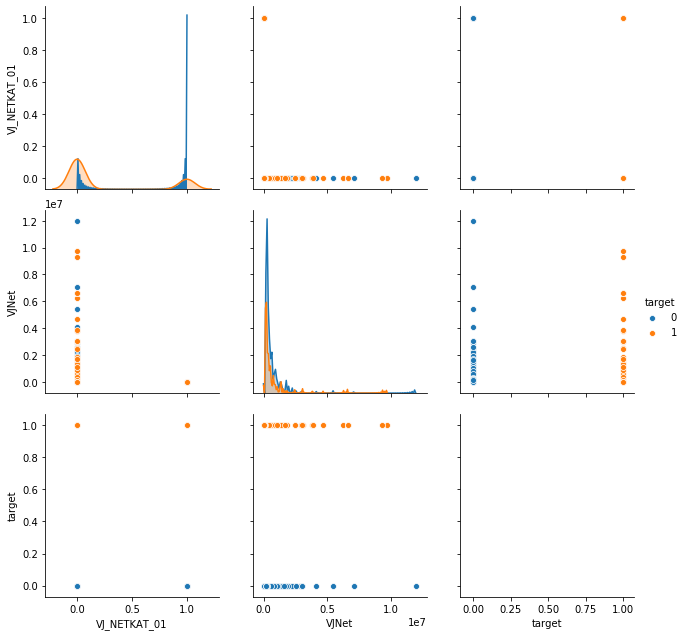

In [14]:
%%time
#pairplot
sns.pairplot(df_describe.loc[:,["VJ_NETKAT_01","VJNet","target"]], hue="target", height=3)
plt.savefig("pairplot.png")
#plt.show()

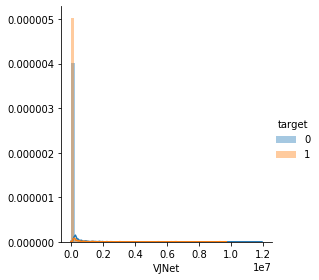

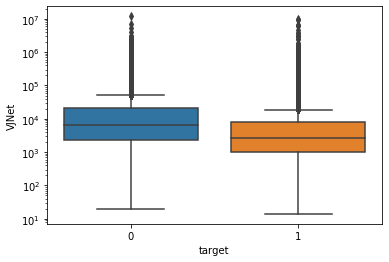

In [15]:
sns.FacetGrid(df_describe, hue="target", height=4).map(sns.distplot,"VJNet").add_legend()
plt.show()
fig, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(x="target",y="VJNet", data=df_describe, ax=ax)
plt.show()

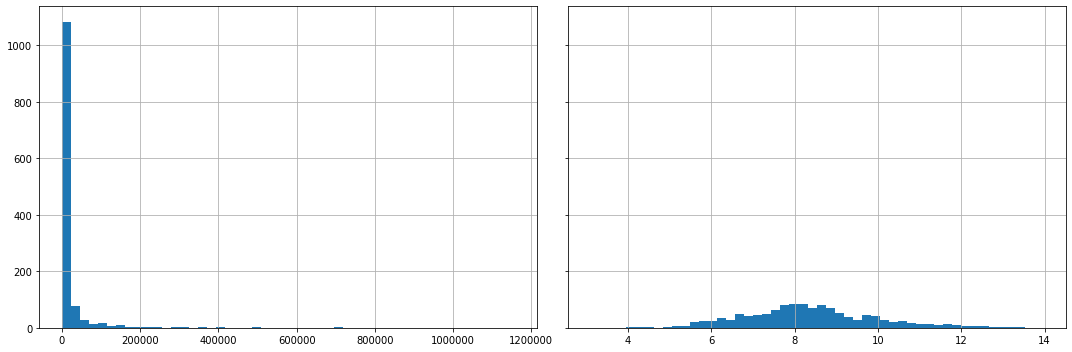

In [16]:
import matplotlib.mlab as mlab
from   matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

x = TDS.loc[TDS.AJ_29>0 ,"AJ_29"]
y = np.log(TDS.loc[TDS.AJ_29>0,"AJ_29"]+1)
n_bins=50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(15,5))

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[0].grid(True)
axs[1].hist(y, bins=n_bins)
axs[1].grid(True)

In [17]:
#TDS.loc[TDS.AJ_29>0,"AJ_29"]

## 3.3 Dataset-Mapping to Zero/One

Prediktor festlegen: Aktuelle Woche basierend auf ``gv_AJAW_KW = 29``:

In [18]:
df_ft_binary = TDS.fillna(0).loc[:,feature_columns+["AJ_29"]]
for col in df_ft_binary.columns:
    df_ft_binary[col] = df_ft_binary[col].map(lambda x: int(bool(x)))

=> ``df_ft_binary``: Dataframe with features and target, all entries as binaries.

### Quick check

In [19]:
final = {0}
for x in list([set(df_ft_binary.loc[:,x]) for x in df_ft_binary.columns]):
    final = final.union(x)
print("All occuring values in df_ft_binary:",final)

All occuring values in df_ft_binary: {0, 1}


# 4. Modelling

## 4.1 Split: Training & Test

In [20]:
df_features = df_ft_binary.loc[:,feature_columns].to_numpy()
df_target   = df_ft_binary.loc[:, "AJ_29"].to_numpy()

In [21]:
#df_features    = TDS.fillna(0).loc[:,feature_columns].to_numpy()
#df_target      = TDS.fillna(0).loc[:,"AJ_29"].to_numpy()

print("Data type:")
print("df_features:", type(df_features))
print("df_target:", type(df_target))
print("\nShape:")
print("df_features:", df_features.shape)
print("df_target:", df_target.shape)
print("\nColumn Names:")
print("Features:\n", feature_columns)
print("Target:", "AJ_29") # <= NEEDS TO BE ADJUSTED!

Data type:
df_features: <class 'numpy.ndarray'>
df_target: <class 'numpy.ndarray'>

Shape:
df_features: (39215, 349)
df_target: (39215,)

Column Names:
Features:
 ['B105', 'B110', 'B115', 'B116', 'B120', 'B125', 'B130', 'B135', 'B140', 'B145', 'B150', 'B155', 'B160', 'B165', 'B170', 'B185', 'B195', 'B225', 'B230', 'B240', 'B241', 'B290', 'B295', 'B325', 'B330', 'B332', 'B334', 'B339', 'B349', 'B350', 'B351', 'B352', 'B353', 'B354', 'B356', 'B357', 'B366', 'B367', 'B371', 'B390', 'B400', 'B401', 'B405', 'B410', 'B420', 'B425', 'B435', 'B436', 'B445', 'B446', 'B447', 'B448', 'B455', 'B460', 'B464', 'B465', 'B466', 'B468', 'B469', 'B470', 'B475', 'B503', 'B504', 'B508', 'B509', 'B535', 'B555', 'B556', 'B575', 'B610', 'B695', 'B705', 'B720', 'B765', 'B780', 'B795', 'B800', 'B901', 'B950', 'B960', 'B970', 'B980', 'B990', 'VJNet', 'VJ_01', 'VJ_03', 'VJ_05', 'VJ_07', 'VJ_09', 'VJ_11', 'VJ_13', 'VJ_15', 'VJ_17', 'VJ_19', 'VJ_21', 'VJ_23', 'VJ_25', 'VJ_27', 'VJ_29', 'VJ_31', 'VJ_33', 'VJ_35', '

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    #df_features, df_target, train_size=0.80, random_state=42)
    df_features, df_target, train_size=0.75, random_state=42)


In [23]:
print("Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shape:
X_train: (29411, 349)
y_train: (29411,)
X_test: (9804, 349)
y_test: (9804,)


In [24]:
from scipy import stats
print('y_train:')
print(pd.DataFrame(y_train).groupby(0)[0].count())
print(stats.describe(y_train))

print('\ny_test:')
print(pd.DataFrame(y_test).groupby(0)[0].count())
print(stats.describe(y_test))

y_train:
0
0    28473
1      938
Name: 0, dtype: int64
DescribeResult(nobs=29411, minmax=(0, 1), mean=0.03189282921355955, variance=0.030876726494310818, skewness=5.328034736308029, kurtosis=26.387954151304978)

y_test:
0
0    9475
1     329
Name: 0, dtype: int64
DescribeResult(nobs=9804, minmax=(0, 1), mean=0.03355773153814769, variance=0.03243491852738443, skewness=5.180165542954156, kurtosis=24.834115052409544)


<div class="alert alert-block alert-info">
<b>Remark:</b> Dataset is massively imbalanced! Only roughly 3% of the Training dataset is 1. This means if I predict all customers to have a Zero, I will be in 97% of the cases correct (on the training set). In order to achieve more reliable scoring models, the training dataset (X_train, y_train) has to be balanced.
</div>

### 4.2 Balance Training Dataset

#### Synthetic Minority Over-sampling Technique (SMOTE)

In [25]:
# pip install imblearn
#from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
#ros = RandomOverSampler(random_state=42)
sm  = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

In [26]:
print('y_train_balanced:')
print(pd.DataFrame(y_train_balanced).groupby(0)[0].count())
print(stats.describe(y_train_balanced))

from collections import Counter
print("\n",sorted(Counter(y_train_balanced).items()))

y_train_balanced:
0
0    28473
1    28473
Name: 0, dtype: int64
DescribeResult(nobs=56946, minmax=(0, 1), mean=0.5, variance=0.25000439020107124, skewness=0.0, kurtosis=-2.0)

 [(0, 28473), (1, 28473)]


## 4.3 Model Training

### 4.3.1 Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

C is the Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

1. logreg:   $C = 1$
2. logreg01: $C = 0.1$
3. logreg00001: $C = 0.0001$
4. logreg100: $C = 100$

In [28]:
def create_logreg(C=[1]):
    logreg_dict = {}
    for x in C:
        logreg_dict[x] = LogisticRegression(n_jobs=-1,
                                    solver="sag",
                                    C=x # to be adjusted
                                   ).fit(X_train_balanced, y_train_balanced)
    return logreg_dict

In [29]:
logreg_dict = create_logreg([1,0.0001,0.01,0.1,100])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [30]:
logreg_dict

{1: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False),
 0.0001: LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False),
 0.01: LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=-1, penalty='l2',
                    random_state=None, solver='sag', tol=0.0001, verbose=0,
                    warm_start=False

In [31]:
logreg_scores = pd.DataFrame([
    [x, logreg_dict[x].score(X_train_balanced, y_train_balanced),
        logreg_dict[x].score(X_test, y_test)] for x in logreg_dict.keys()], columns=["LogReg C", "Training set score","Test Set score"])

In [32]:
logreg_scores

,LogReg C,Training set score,Test Set score
0,1.0000,0.834510,0.757344
1,0.0001,0.706529,0.582823
2,0.0100,0.795824,0.695532
3,0.1000,0.823552,0.741228
4,100.0000,0.837425,0.758160


In [136]:
%%time
logreg = LogisticRegression(n_jobs=-1,
                            max_iter=100000,
                            solver="sag",
                            C=1 # to be adjusted
                           ).fit(X_train_balanced, y_train_balanced)

#logreg = LogisticRegression().fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.835
Test set score: 0.757
Wall time: 24.7 s


In [134]:
%%time
# %% Train data: LogReg with C = 0.01
logreg001 = LogisticRegression(n_jobs=-1,
                               max_iter=100000,
                               solver="sag", # L2 regularisation
                               C=0.01 # adjustable
                              ).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.3f}".format(logreg001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

Training set score: 0.796
Test set score: 0.696
Wall time: 2.54 s


In [35]:
%%time
logreg00001 = LogisticRegression(n_jobs=-1,
                                 max_iter=100000,
                               solver="sag",
                               C=0.0001 # adjustable
                              ).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.3f}".format(logreg00001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg00001.score(X_test, y_test)))

Training set score: 0.707
Test set score: 0.583
Wall time: 1.88 s


In [135]:
%%time
logreg100 = LogisticRegression(n_jobs=-1,
                               solver="sag",
                               max_iter=100000,
                               C=100 #adjustable
                              ).fit(X_train_balanced, y_train_balanced) # bigger C

print("Training set score: {:.3f}".format(logreg100.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

Training set score: 0.842
Test set score: 0.763
Wall time: 3min 38s


#### Plot coefficients

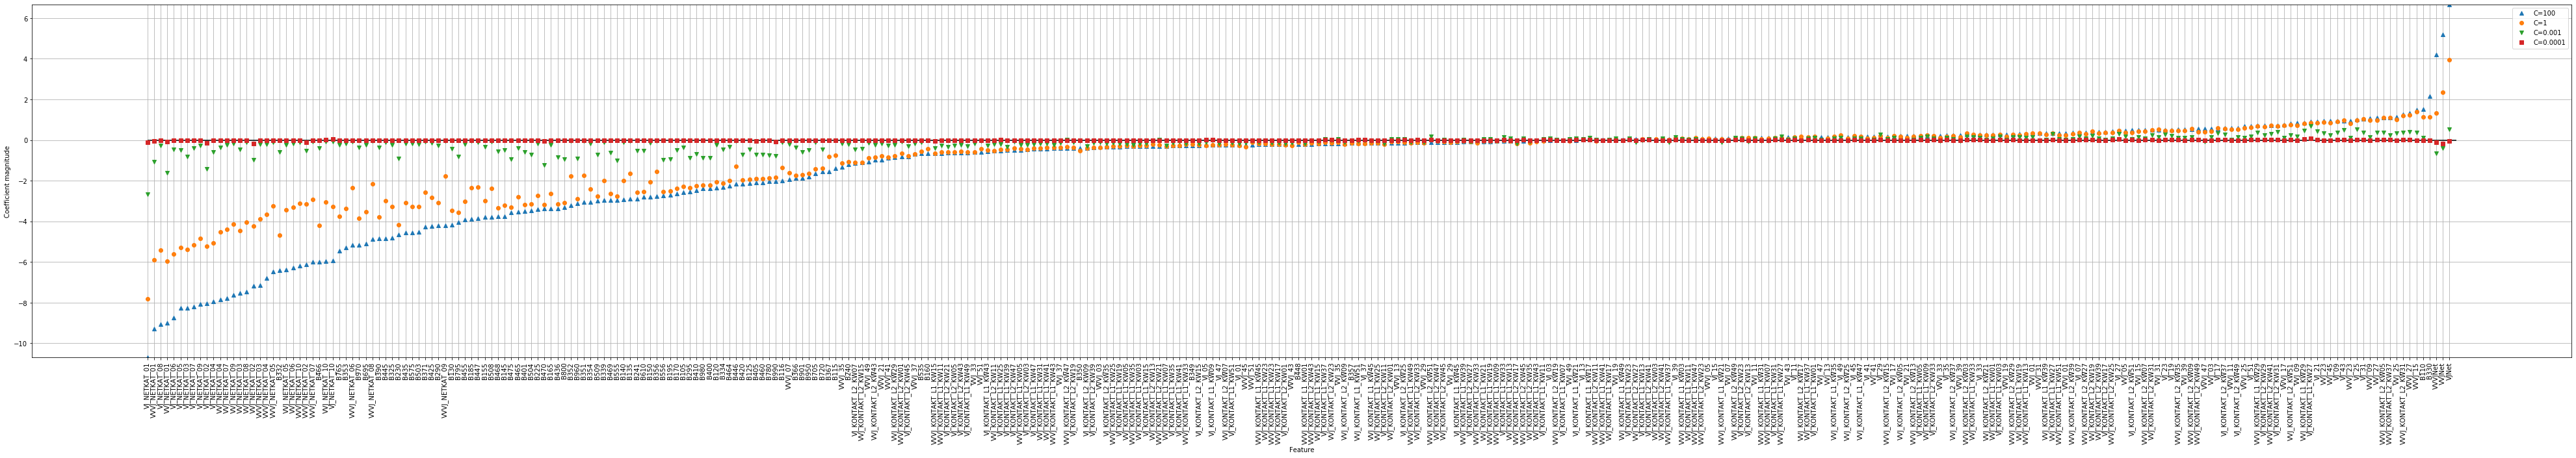

In [37]:
temp = np.asarray([x for [x] in logreg100.coef_.T]).argsort()
ranks= np.empty_like(temp)
ranks[temp] = np.arange(len(temp))

sorted_logreg100       = [0 for x in range(len(temp))]
sorted_logreg          = [0 for x in range(len(temp))]
sorted_logreg001       = [0 for x in range(len(temp))]
sorted_logreg00001     = [0 for x in range(len(temp))]
sorted_feature_columns = [0 for x in range(len(temp))]
for i in range(len(temp)):
    sorted_logreg100[ranks[i]]       = logreg100.coef_.T[i]
    sorted_logreg[ranks[i]]          = logreg.coef_.T[i]
    sorted_logreg001[ranks[i]]       = logreg001.coef_.T[i]
    sorted_logreg00001[ranks[i]]     = logreg00001.coef_.T[i]
    sorted_feature_columns[ranks[i]] = feature_columns[i]
    
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(sorted_logreg100 , '^', label="C=100")
plt.plot(sorted_logreg,    'o', label="C=1")
plt.plot(sorted_logreg001, 'v', label="C=0.001")
plt.plot(sorted_logreg00001, 's', label="C=0.0001")
plt.xticks(range(len(feature_columns)), sorted_feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg100.coef_.T), max(logreg100.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

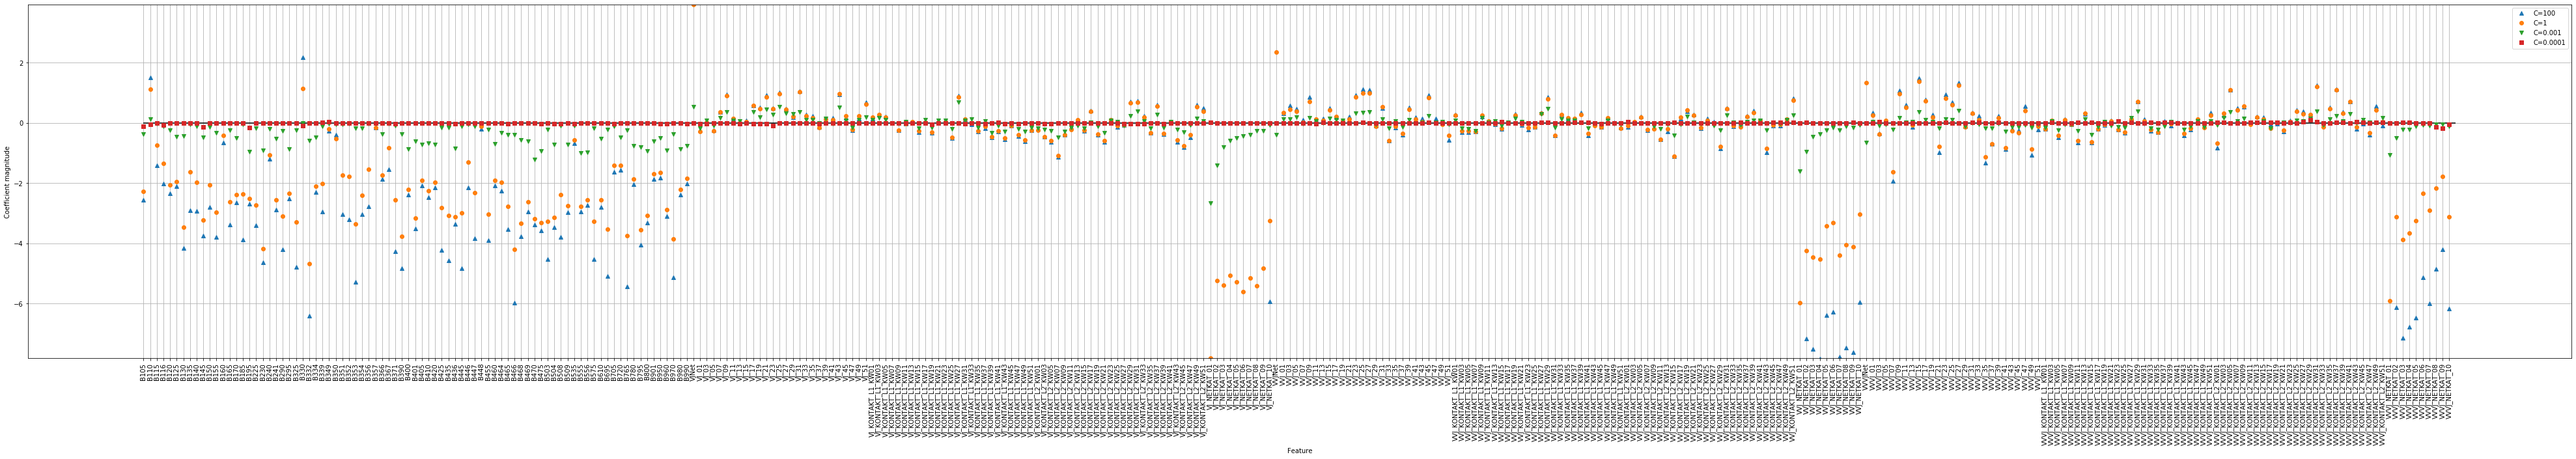

In [38]:
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T,    'o', label="C=1")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.plot(sorted_logreg00001, 's', label="C=0.0001")
plt.xticks(range(len(feature_columns)), feature_columns, rotation=90)
plt.hlines(0, 0, len(feature_columns))
plt.ylim(min(logreg.coef_.T), max(logreg.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

### 4.3.2. Lasso

In [39]:
from sklearn.linear_model import Lasso

In [40]:
%%time
lasso = Lasso().fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Training set score: 0.00
Test set score: -6.71
Number of features used: 0
Wall time: 376 ms


In [41]:
%%time
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso001.coef_ != 0))

Training set score: 0.14
Test set score: -5.87
Number of features used: 8
Wall time: 516 ms


In [42]:
%%time

lasso00000001 = Lasso(alpha=0.0000001, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso00000001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso00000001.score(X_test,      y_test)))
print("Number of features used:", np.sum(lasso00000001.coef_ != 0))

Training set score: 0.40
Test set score: -4.73
Number of features used: 349
Wall time: 8.18 s


In [43]:
%%time
lasso000001 = Lasso(alpha=0.0001, max_iter=100000).fit(X_train_balanced, y_train_balanced)

print("Training set score: {:.2f}".format(lasso000001.score(X_train_balanced, y_train_balanced)))
print("Test set score: {:.2f}".format(lasso000001.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso000001.coef_ != 0))

Training set score: 0.39
Test set score: -4.65
Number of features used: 293
Wall time: 2.34 s


=> ALL SUPERMASSIVE CRAP

### 4.3.3 Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
%%time

forest = RandomForestClassifier(n_estimators=10000,
                                max_depth=35,
                                random_state=42,
                                n_jobs=-1)
forest.fit(X_train_balanced, y_train_balanced)

# %% Validate Accuracy
print("Accuracy on training set: {:.3f}".format(forest.score(X_train_balanced,y_train_balanced)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test,     y_test)))

Accuracy on training set: 0.920
Accuracy on test set: 0.812
Wall time: 9min 20s


In [46]:
# %% Plot: Feature importance
def plot_feature_importances(model,feature_columns,figsize=(20,100)):
    from operator import itemgetter
    dict_feature_importance = sorted(dict(zip(feature_columns,model.feature_importances_)).items(), key=itemgetter(1))
    n_features              = len(feature_columns)
    
    plt.figure(figsize=figsize)
    plt.grid()
    plt.barh(np.arange(n_features),
             [y for (x,y) in dict_feature_importance],
             align='center')
    plt.yticks(np.arange(n_features), [x for (x,y) in dict_feature_importance])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)
    plt.show()

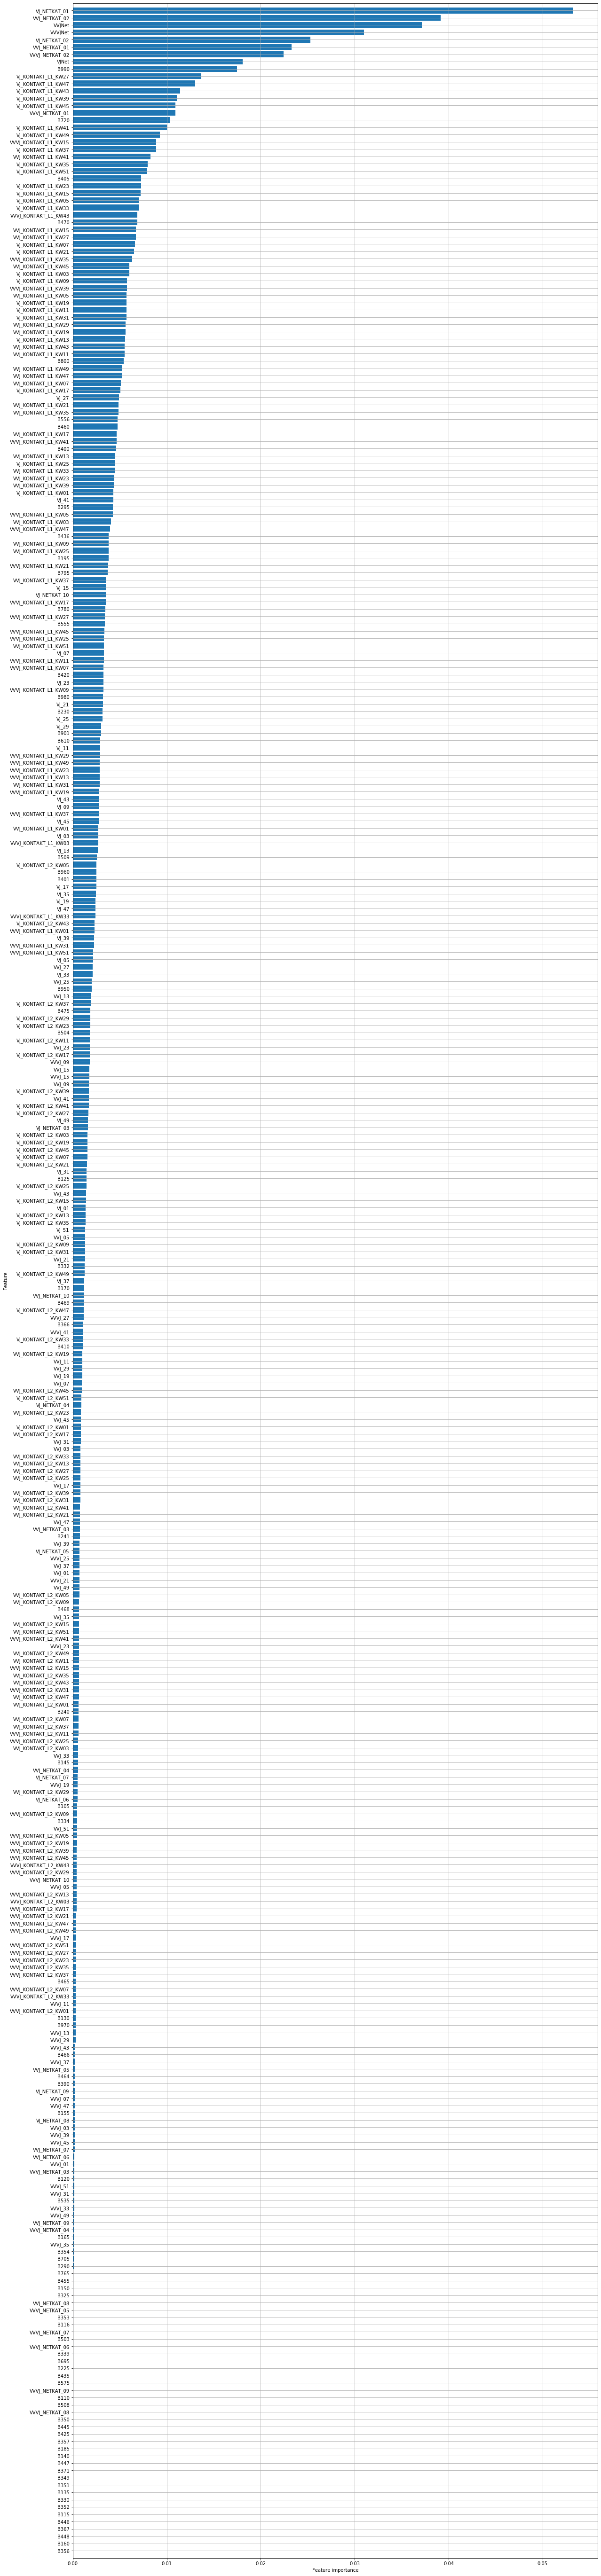

In [47]:
plot_feature_importances(forest,feature_columns)
#plot_feature_importances(forest_selected,feature_columns_selected)

# 5. Automated Feature selection: SelectPercentile

In [48]:
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif # ANOVA F-value
from sklearn.feature_selection import mutual_info_classif

``SelectPercentile`` removes all but a user-specified highest scoring percentage of features.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html

1. ``f_classif `` ANOVA assumes normal distribution. (nope)
2. ``mutual_info_classif`` Mutual information for a discrete target.
3. ``chi2`` Chis-squared starts of non-negative features for classification tasks.
4. ``f_regression`` F-value between label/feature for regression tasks.
5. ``mutual_info_regression`` Mutual information for a continuous target.
6. ``SelectKBest`` Select features based on the k highest scores
7. ``SelectFpr`` Select features based on a FPR test.
8. ``SelectFdr`` Select features based on an estimated false discovery rate
9. ``SelectFwe`` Select features based on family-wise error rate.
10. ``GenericUnivariateSelect`` Univariate feature selector with configurable mode.

In [49]:
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(score_func=mutual_info_classif,
                          percentile=50)
select.fit(X_train_balanced, y_train_balanced)
# transform training set
X_train_selected = select.transform(X_train_balanced) # not needed. we have the mask (logical array).

print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train_balanced.shape: (56946, 349)
X_train_selected.shape: (56946, 174)


[False  True False False  True False False False  True False False False
 False  True  True  True  True False  True False False  True  True  True
  True  True  True  True False  True False False  True  True False False
 False  True False False  True False  True  True  True  True False  True
 False  True False  True False  True False  True False  True False  True
 False False  True False  True False  True  True False False  True False
  True  True False  True  True False False  True  True  True  True  True
  True False False False  True False  True  True False  True  True False
  True  True  True False  True  True False False False False False False
 False  True False False  True  True  True False False  True False False
 False  True  True  True  True False False False False  True  True  True
 False False  True False False False  True  True False False  True False
 False False  True  True  True  True  True  True  True False  True False
 False False  True False False  True  True  True Fa

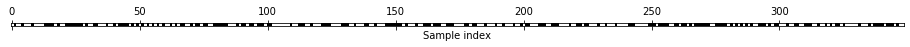

In [50]:
mask = select.get_support()
print(mask)
# visualize the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

In [51]:
from itertools import compress

feature_columns_selected = list(compress(feature_columns,mask))
print(feature_columns_selected)
#print(feature_columns)

['B110', 'B120', 'B140', 'B165', 'B170', 'B185', 'B195', 'B230', 'B290', 'B295', 'B325', 'B330', 'B332', 'B334', 'B339', 'B350', 'B353', 'B354', 'B367', 'B400', 'B405', 'B410', 'B420', 'B425', 'B436', 'B446', 'B448', 'B460', 'B465', 'B468', 'B470', 'B504', 'B509', 'B555', 'B556', 'B695', 'B720', 'B765', 'B795', 'B800', 'B960', 'B970', 'B980', 'B990', 'VJNet', 'VJ_01', 'VJ_09', 'VJ_13', 'VJ_15', 'VJ_19', 'VJ_21', 'VJ_25', 'VJ_27', 'VJ_29', 'VJ_33', 'VJ_35', 'VJ_51', 'VJ_KONTAKT_L1_KW05', 'VJ_KONTAKT_L1_KW07', 'VJ_KONTAKT_L1_KW09', 'VJ_KONTAKT_L1_KW15', 'VJ_KONTAKT_L1_KW23', 'VJ_KONTAKT_L1_KW25', 'VJ_KONTAKT_L1_KW27', 'VJ_KONTAKT_L1_KW31', 'VJ_KONTAKT_L1_KW41', 'VJ_KONTAKT_L1_KW43', 'VJ_KONTAKT_L1_KW45', 'VJ_KONTAKT_L1_KW51', 'VJ_KONTAKT_L2_KW07', 'VJ_KONTAKT_L2_KW09', 'VJ_KONTAKT_L2_KW15', 'VJ_KONTAKT_L2_KW23', 'VJ_KONTAKT_L2_KW25', 'VJ_KONTAKT_L2_KW27', 'VJ_KONTAKT_L2_KW29', 'VJ_KONTAKT_L2_KW31', 'VJ_KONTAKT_L2_KW33', 'VJ_KONTAKT_L2_KW35', 'VJ_KONTAKT_L2_KW39', 'VJ_KONTAKT_L2_KW47', 'V

In [52]:
print("X_train_balanced.shape: {}".format(X_train_balanced.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_train_balanced[:,mask].shape: {}".format(X_train_balanced[:,mask].shape))

X_train_balanced.shape: (56946, 349)
X_train_selected.shape: (56946, 174)
X_train_balanced[:,mask].shape: (56946, 174)


In [53]:
%%time
logreg_selected = LogisticRegression(n_jobs=-1,
                            solver="sag",
                            C=1 # to be adjusted
                           ).fit(X_train_balanced[:,mask], # We select only those we need
                                 y_train_balanced)

forest_selected = RandomForestClassifier(n_estimators=10000,
                                max_depth=35,
                                random_state=42,
                                n_jobs=-1)

forest_selected.fit(X_train_balanced[:,mask],
           y_train_balanced)

Wall time: 8min 20s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=35, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [54]:
# %% Validate Accuracy
print("Random Forest, newly selected features:")
print("Accuracy on training set: {:.3f}".format(forest_selected.score(X_train_balanced[:,mask],
                                                             y_train_balanced)))

print("Accuracy on test set: {:.3f}".format(forest_selected.score(X_test[:,mask],
                                                         y_test)))

print("\nLogististic Regression C=1, newly selected features:")
print("Training set score: {:.3f}".format(logreg_selected.score(X_train_balanced[:,mask], # Obviously only applicable to the subselect
                                                                y_train_balanced))) 
print("Test set score: {:.3f}".format(logreg_selected.score(X_test[:,mask], # Obviously only applicable to the subselect
                                                            y_test)))

print("\nLogististic Regression C=1, all features:")
print("Training set score: {:.3f}".format(logreg.score(X_train_balanced,y_train_balanced))) 
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

print("\nRandom Forest, all features:")
print("Accuracy on training set: {:.3f}".format(forest.score(X_train_balanced,
                                                             y_train_balanced)))

print("Accuracy on test set: {:.3f}".format(forest.score(X_test,
                                                         y_test)))
print("\n")

Random Forest, newly selected features:
Accuracy on training set: 0.896
Accuracy on test set: 0.778

Logististic Regression C=1, newly selected features:
Training set score: 0.798
Test set score: 0.706

Logististic Regression C=1, all features:
Training set score: 0.835
Test set score: 0.757

Random Forest, all features:
Accuracy on training set: 0.920
Accuracy on test set: 0.812




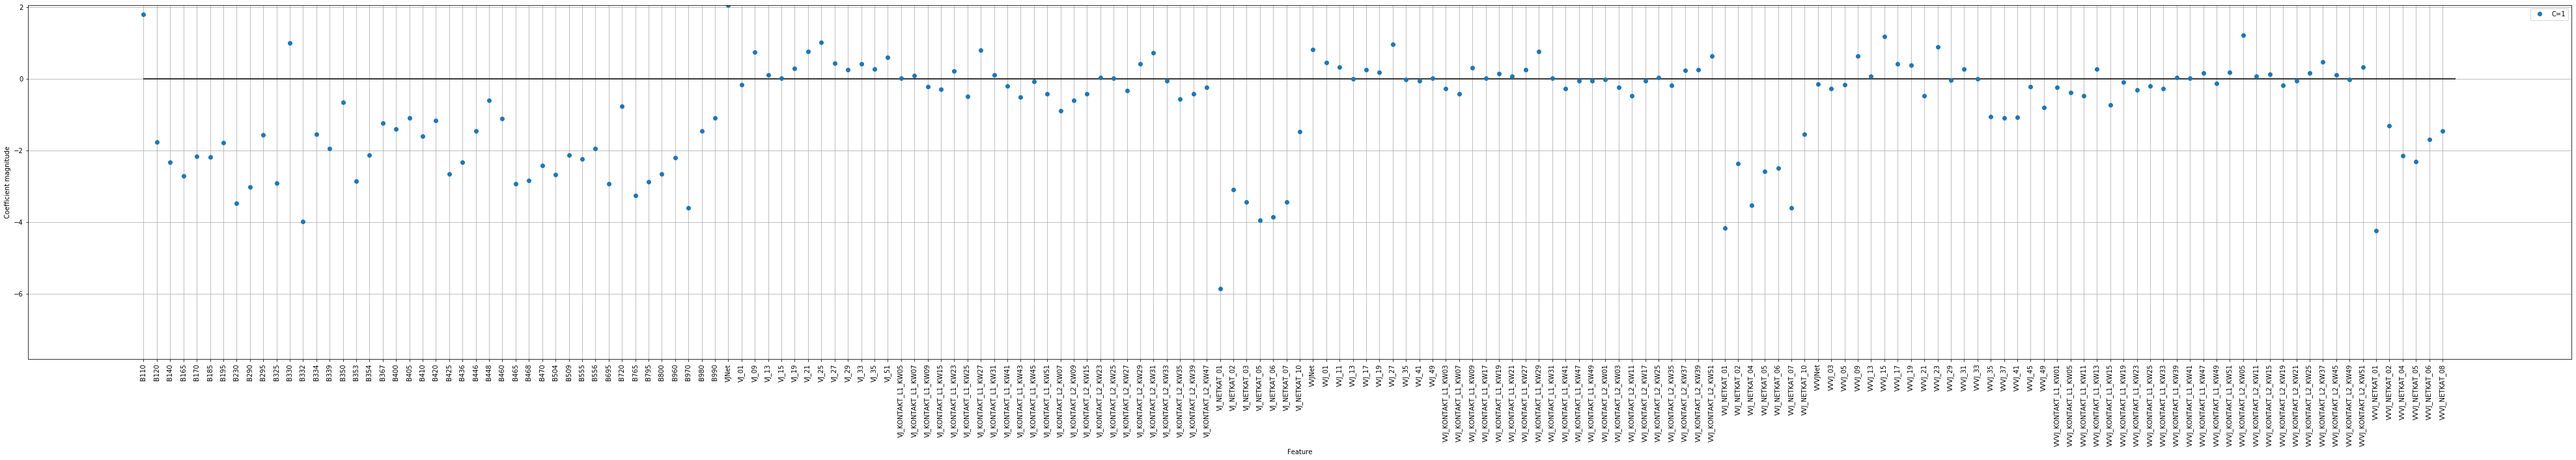

In [55]:
# %% Plot: Compare LogReg-coefficients for different C (1, 100, 0.001)
plt.figure(figsize=(70,10))
plt.grid()
plt.plot(logreg_selected.coef_.T,    'o', label="C=1")
plt.xticks(range(len(feature_columns_selected)), feature_columns_selected, rotation=90)
plt.hlines(0, 0, len(feature_columns_selected))
plt.ylim(min(logreg.coef_.T), max(logreg_selected.coef_.T))
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()
plt.savefig('this_is_a_test.png')

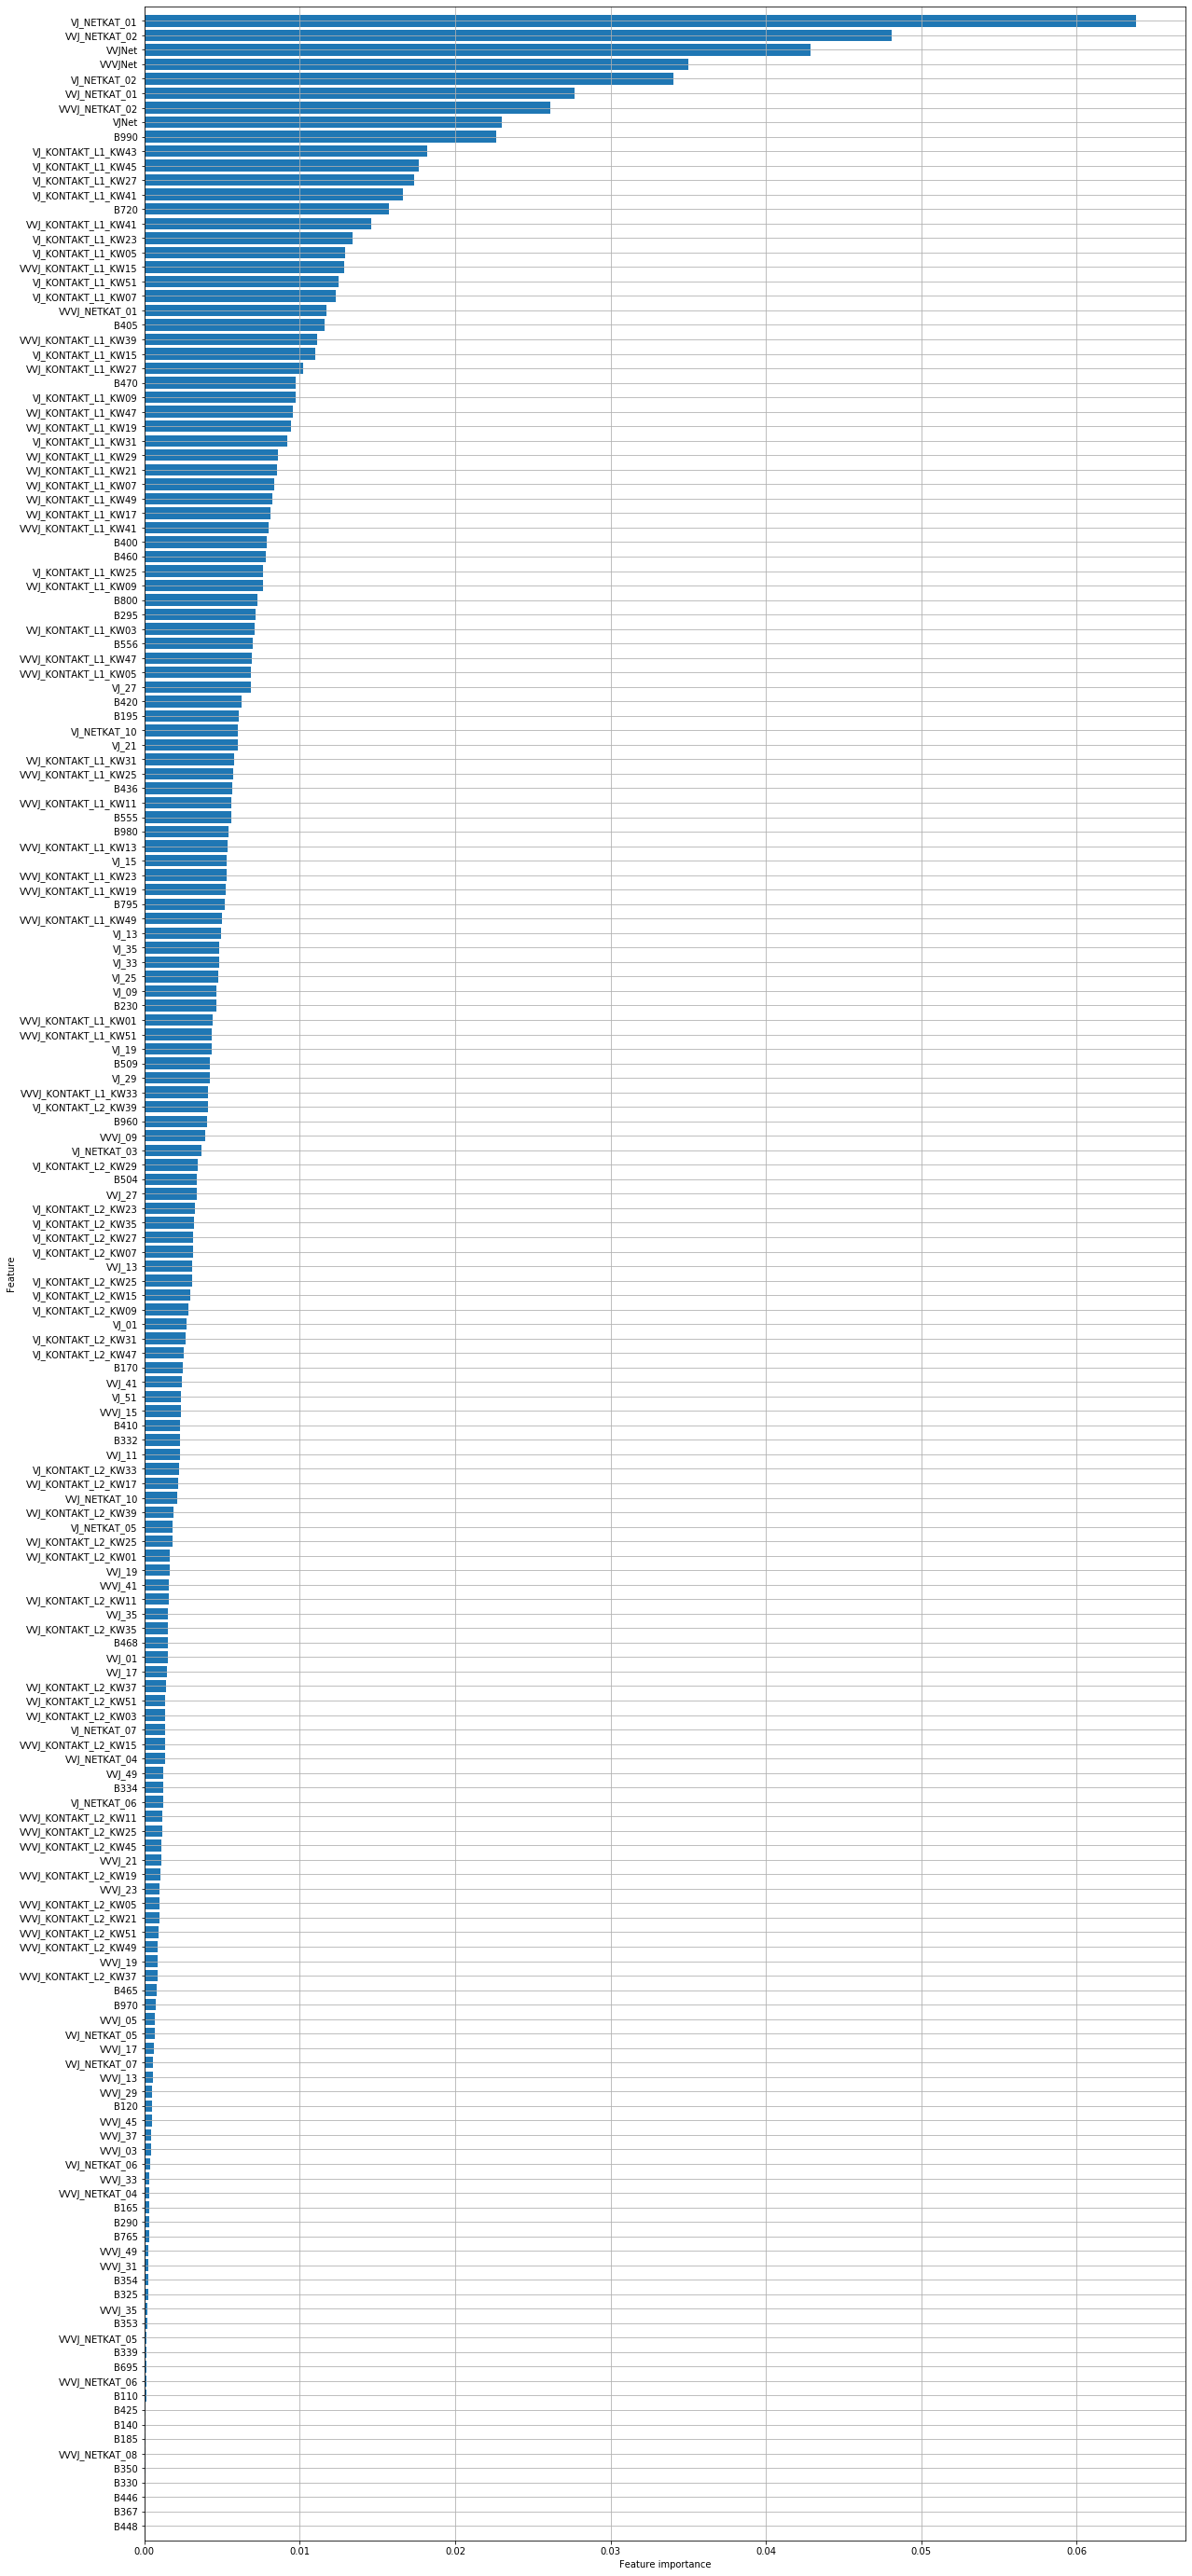

In [56]:
plot_feature_importances(forest_selected,feature_columns_selected,figsize=(20,50))

# X. Cross-Validation in Scikit-Learn

1. https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/ch05.html#model-evaluation-and-improvement
3. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html


In [57]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg,
                         np.concatenate([X_train_balanced,X_test]),
                         np.concatenate([y_train_balanced,y_test]), 
                         cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.8119242  0.84712756 0.8470412  0.84163608 0.82710315]


In [58]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.83


In [59]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg,
                     np.concatenate([X_train_balanced,X_test]),
                     np.concatenate([y_train_balanced,y_test]),
                     cv=5,
                     return_train_score=True)
res_df = pd.DataFrame(res)
display(res_df)
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,14.038486,0.028894,0.811924,0.846177
1,14.005571,0.027900,0.847128,0.836308
2,14.062515,0.029919,0.847041,0.833558
3,15.629370,0.029920,0.841636,0.835846
4,14.136838,0.030888,0.827103,0.840827


Mean times and scores:
 fit_time       14.374556
score_time      0.029504
test_score      0.834966
train_score     0.838543
dtype: float64


# 6. Model Validatian 

## 6.1 Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
%%time
#logreg = LogisticRegression(C=1, solver='lbfgs').fit(X_train_binary, y_train_binary)
pred_logreg          = logreg.predict(X_test)
pred_logreg_selected = logreg_selected.predict(X_test[:,mask])
pred_forest          = forest.predict(X_test)
pred_forest_selected = forest_selected.predict(X_test[:,mask])

Wall time: 1min 24s


In [62]:
%%time
confusion_logreg             = confusion_matrix(y_test, pred_logreg)
df_confusion_logreg          = pd.DataFrame(confusion_logreg, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_logreg_selected    = confusion_matrix(y_test, pred_logreg_selected)
df_confusion_logreg_selected = pd.DataFrame(confusion_logreg_selected, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_forest             = confusion_matrix(y_test, pred_forest)
df_confusion_forest          = pd.DataFrame(confusion_forest, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

confusion_forest_selected    = confusion_matrix(y_test, pred_forest_selected)
df_confusion_forest_selected = pd.DataFrame(confusion_forest_selected, index=["Fact 0", "Fact 1"], columns=["Pred 0","Pred 1"])

print("Test set balance:")
print(sorted(Counter(y_test).items()),"\n")

print("Confusion Matrices:")

print("Logistic Regression C=1:")
display(df_confusion_logreg)

print("Logistic Regression C=1, newly selected features:")
display(df_confusion_logreg_selected)

print("Random Forest:")
display(df_confusion_forest)

print("Random Forest, newly selected features:")
display(df_confusion_forest_selected)

Test set balance:
[(0, 9475), (1, 329)] 

Confusion Matrices:
Logistic Regression C=1:


,Pred 0,Pred 1
Fact 0,7314,2161
Fact 1,218,111


Logistic Regression C=1, newly selected features:


,Pred 0,Pred 1
Fact 0,6791,2684
Fact 1,201,128


Random Forest:


,Pred 0,Pred 1
Fact 0,7878,1597
Fact 1,251,78


Random Forest, newly selected features:


,Pred 0,Pred 1
Fact 0,7541,1934
Fact 1,245,84


Wall time: 107 ms


In [63]:
#import mglearn
#mglearn.plots.plot_binary_confusion_matrix()

1. $Precision =\frac{TP}{TP+FP}$
2. $Recall =\frac{TP}{TP+FN}$
3. $f_{1} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{2 \cdot TP}{2 \cdot TP + (FN + FP)}$
4. $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$ KPI combines Precision and Recall


In [64]:
from sklearn.metrics import classification_report
print("Logistic Regression C=1:")
print(classification_report(y_test,
                            pred_logreg,
                            target_names=["not booking = 0", "booking = 1"]))
print("\n")
print("Logistic Regression C=1, newly selected features:")
print(classification_report(y_test,
                            pred_logreg_selected,
                            target_names=["not booking = 0", "booking = 1"]))
print("\n")
print("Random Forest:")
print(classification_report(y_test,
                            pred_forest,
                            target_names=["not booking = 0", "booking = 1"]))

print("\n")
print("Random Forest, new selected:")
print(classification_report(y_test,
                            pred_forest_selected,
                            target_names=["not booking = 0", "booking = 1"]))

Logistic Regression C=1:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.77      0.86      9475
    booking = 1       0.05      0.34      0.09       329

       accuracy                           0.76      9804
      macro avg       0.51      0.55      0.47      9804
   weighted avg       0.94      0.76      0.83      9804



Logistic Regression C=1, newly selected features:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.72      0.82      9475
    booking = 1       0.05      0.39      0.08       329

       accuracy                           0.71      9804
      macro avg       0.51      0.55      0.45      9804
   weighted avg       0.94      0.71      0.80      9804



Random Forest:
                 precision    recall  f1-score   support

not booking = 0       0.97      0.83      0.90      9475
    booking = 1       0.05      0.24      0.08       329

       accuracy                           0

Lower the Threshold:

In [65]:
def threshold_test(number):
    y_pred_lower_threshold = logreg.decision_function(X_test) > number
    print(classification_report(y_test, y_pred_lower_threshold))

In [66]:
threshold_test(0.1)

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      9475
           1       0.05      0.32      0.09       329

    accuracy                           0.77      9804
   macro avg       0.51      0.55      0.48      9804
weighted avg       0.94      0.77      0.84      9804



In [137]:
def prob_threshold(number):
    y_pred_prob_threshold = np.asarray([y for [x,y] in logreg100.predict_proba(X_test)]) > number
    print(classification_report(y_test, y_pred_prob_threshold))

In [138]:
for x in np.around(np.arange(0,1,0.1),decimals=1):
    print("Prob =",x,":")
    print(prob_threshold(x),"\n")


Prob = 0.0 :
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9475
           1       0.03      1.00      0.06       329

    accuracy                           0.03      9804
   macro avg       0.02      0.50      0.03      9804
weighted avg       0.00      0.03      0.00      9804

None 

Prob = 0.1 :


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      0.45      0.62      9475
           1       0.04      0.58      0.07       329

    accuracy                           0.46      9804
   macro avg       0.50      0.51      0.34      9804
weighted avg       0.94      0.46      0.60      9804

None 

Prob = 0.2 :
              precision    recall  f1-score   support

           0       0.97      0.57      0.72      9475
           1       0.04      0.47      0.07       329

    accuracy                           0.56      9804
   macro avg       0.50      0.52      0.39      9804
weighted avg       0.94      0.56      0.69      9804

None 

Prob = 0.3 :
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      9475
           1       0.04      0.40      0.07       329

    accuracy                           0.64      9804
   macro avg       0.50      0.52      0.42      9804
weighted avg       0.94      0.64 

In [68]:
import seaborn as sns

def boxplot_histogram(x, bins=None, figsize=(15,10)):
    sns.set(style="ticks")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)},
                                        figsize=figsize)

    sns.boxplot(x, notch=True,ax=ax_box)
    sns.distplot(x, ax=ax_hist,bins=bins)
    ax_hist.grid(True)
    ax_hist.set_title('Historgram')
    ax_hist.set_ylabel('Percentage')
    ax_hist.set_xlabel('Value Range')

    ax_box.set(yticks=[])
    ax_box.set_title('Boxplot')
    ax_box.grid(True)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    
    plt.show()
    

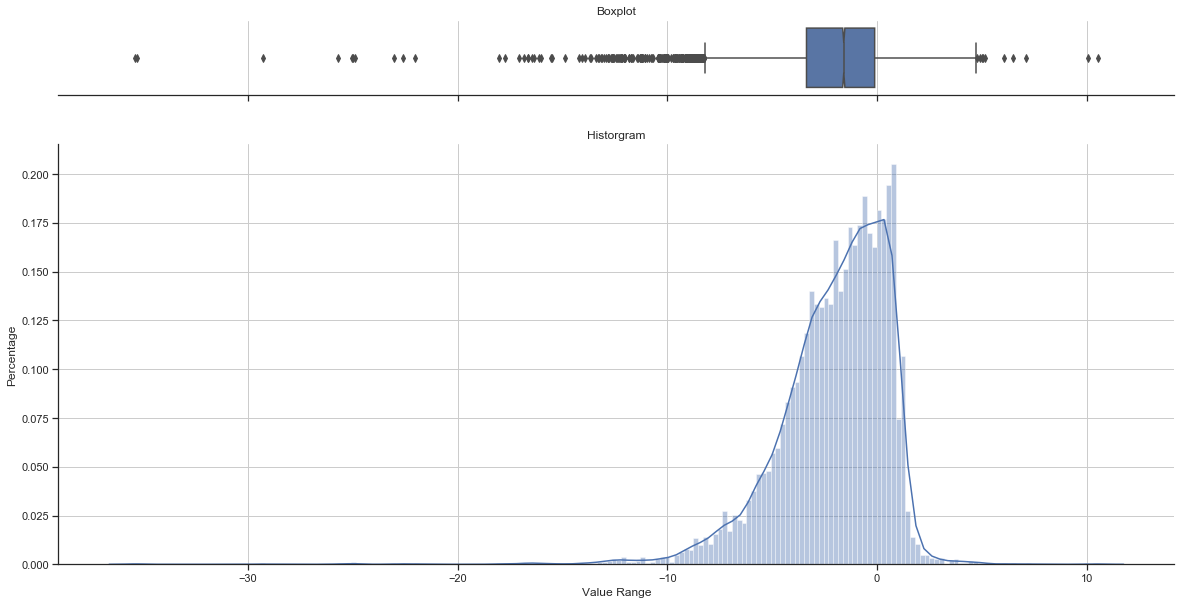

In [69]:
boxplot_histogram(logreg_pred_decision,
                  bins=200,
                  figsize=(20,10))

In [70]:
threshold_test(-100)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9475
           1       0.03      1.00      0.06       329

    accuracy                           0.03      9804
   macro avg       0.02      0.50      0.03      9804
weighted avg       0.00      0.03      0.00      9804



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 6.2 Precision-Recall curve

In [88]:
%%time
from sklearn.metrics import precision_recall_curve

def prec_rec_curve(X_test,y_test):
    global precision_logreg, recall_logreg, thresholds_logreg, precision_logreg_selected, recall_logreg_selected, thresholds_logreg_selected, precision_forest, recall_forest, thresholds_forest, precision_forest_selected, recall_forest_selected, thresholds_forest_selected
    
    precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(
        y_test, 
        logreg.decision_function(X_test))

    #
    precision_logreg_selected, recall_logreg_selected, thresholds_logreg_selected = precision_recall_curve(
        y_test, 
        logreg_selected.decision_function(X_test[:,mask]))

    # RandomForestClassifier has predict_proba, but not decision_function
    precision_forest, recall_forest, thresholds_forest = precision_recall_curve(
        y_test,
        forest.predict_proba(X_test)[:, 1])

    precision_forest_selected, recall_forest_selected, thresholds_forest_selected = precision_recall_curve(
        y_test,
        forest_selected.predict_proba(X_test[:,mask])[:, 1])


Wall time: 0 ns


In [91]:
%%time
#prec_rec_curve(X_test,y_test)
prec_rec_curve(X_train,y_train)

Wall time: 1min 33s


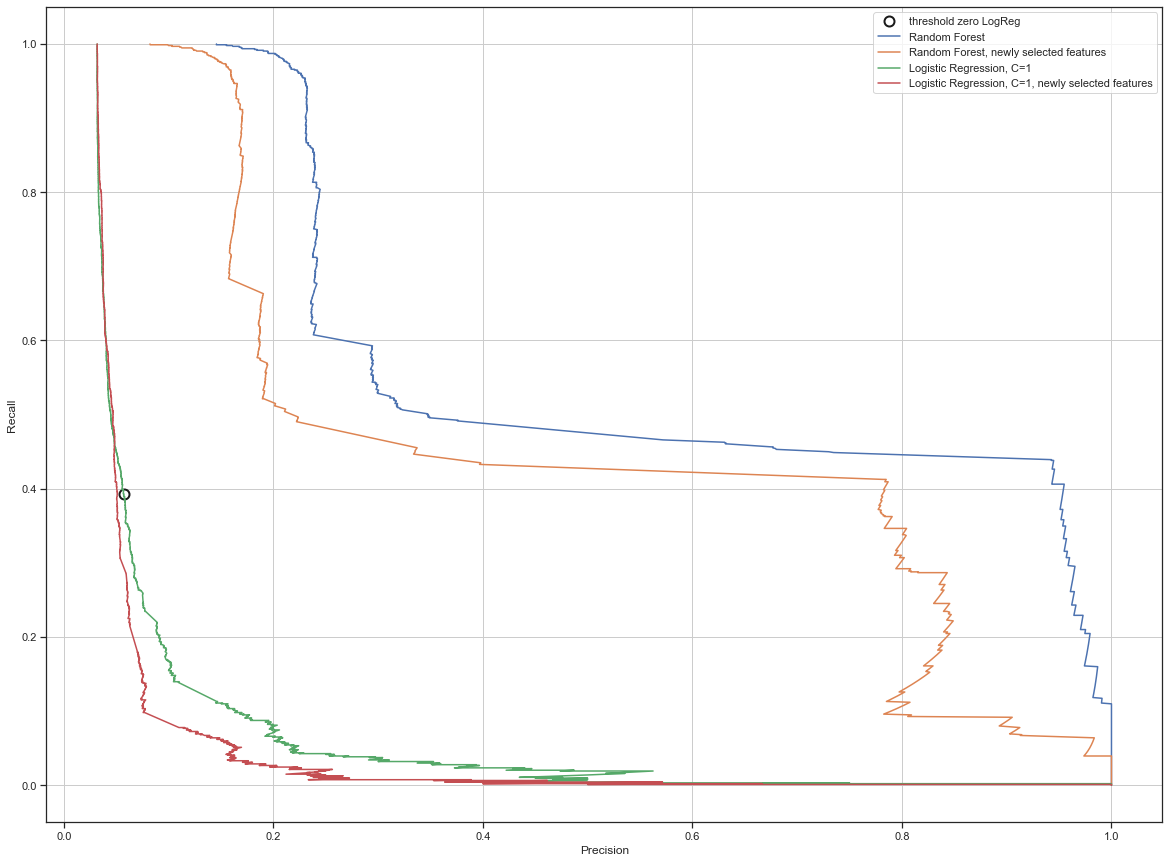

In [92]:
plt.figure(figsize=(20,15))
plt.grid()

close_zero = np.argmin(np.abs(thresholds_logreg))
plt.plot(precision_logreg[close_zero],
         recall_logreg[close_zero],
         'o',
         markersize=10,
         label="threshold zero LogReg",
         fillstyle="none",
         c='k',
         mew=2)

plt.plot(precision_forest, recall_forest, label="Random Forest")
plt.plot(precision_forest_selected, recall_forest_selected, label="Random Forest, newly selected features")
plt.plot(precision_logreg, recall_logreg, label="Logistic Regression, C=1")
plt.plot(precision_logreg_selected, recall_logreg_selected, label="Logistic Regression, C=1, newly selected features")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

plt.show()

<div class="alert alert-block alert-info">
<b>Remark:</b> This plot looks horrible. HORRIBLE!!!
</div>

In [93]:
%%time
from sklearn.metrics import average_precision_score # Area under the Recall/Precision-curves

avg_precision_forest = average_precision_score(y_test,
                                               forest.predict_proba(X_test)[:, 1])

avg_precision_forest_selected = average_precision_score(y_test,
                                               forest_selected.predict_proba(X_test[:,mask])[:, 1])

avg_precision_logreg = average_precision_score(y_test,
                                               logreg.decision_function(X_test))

avg_precision_logreg_selected = average_precision_score(y_test,
                                               logreg_selected.decision_function(X_test[:,mask]))

print("Average Precision of Random Forest: {:.3f}".format(avg_precision_forest))
print("Average Precision of Random Forest, newly selected features: {:.3f}".format(avg_precision_forest_selected))
print("Average Precision of Logistic Regression C=1: {:.3f}".format(avg_precision_logreg))
print("Average Precision of Logistic Regression C=1, newly selected features: {:.3f}".format(avg_precision_logreg_selected))

Average Precision of Random Forest: 0.047
Average Precision of Random Forest, newly selected features: 0.046
Average Precision of Logistic Regression C=1: 0.060
Average Precision of Logistic Regression C=1, newly selected features: 0.055
Wall time: 1min 25s


## 6.3 Receiver operating characteristics (ROC) and AUC

1. $FPR = \frac{FP}{FP + TN}$ 
2. $TPR = Recall$

In [74]:
%%time
from sklearn.metrics import roc_curve

fpr_logreg,          tpr_logreg,          thresholds_logreg      = roc_curve(y_test, logreg.decision_function(X_test))
fpr_logreg00001,     tpr_logreg00001,     thresholds_logreg00001 = roc_curve(y_test, logreg00001.decision_function(X_test))
fpr_logreg001,       tpr_logreg001,       thresholds_logreg001       = roc_curve(y_test, logreg001.decision_function(X_test))
fpr_logreg100,       tpr_logreg100,       thresholds_logreg100       = roc_curve(y_test, logreg100.decision_function(X_test))
fpr_logreg_selected, tpr_logreg_selected, thresholds_logreg_selected = roc_curve(y_test, logreg_selected.decision_function(X_test[:,mask]))
fpr_forest,          tpr_forest,          thresholds_forest      = roc_curve(y_test, forest.predict_proba(X_test)[:, 1])
fpr_forest_selected, tpr_forest_selected, thresholds_forest_selected = roc_curve(y_test, forest_selected.predict_proba(X_test[:,mask])[:, 1])

Wall time: 1min 25s


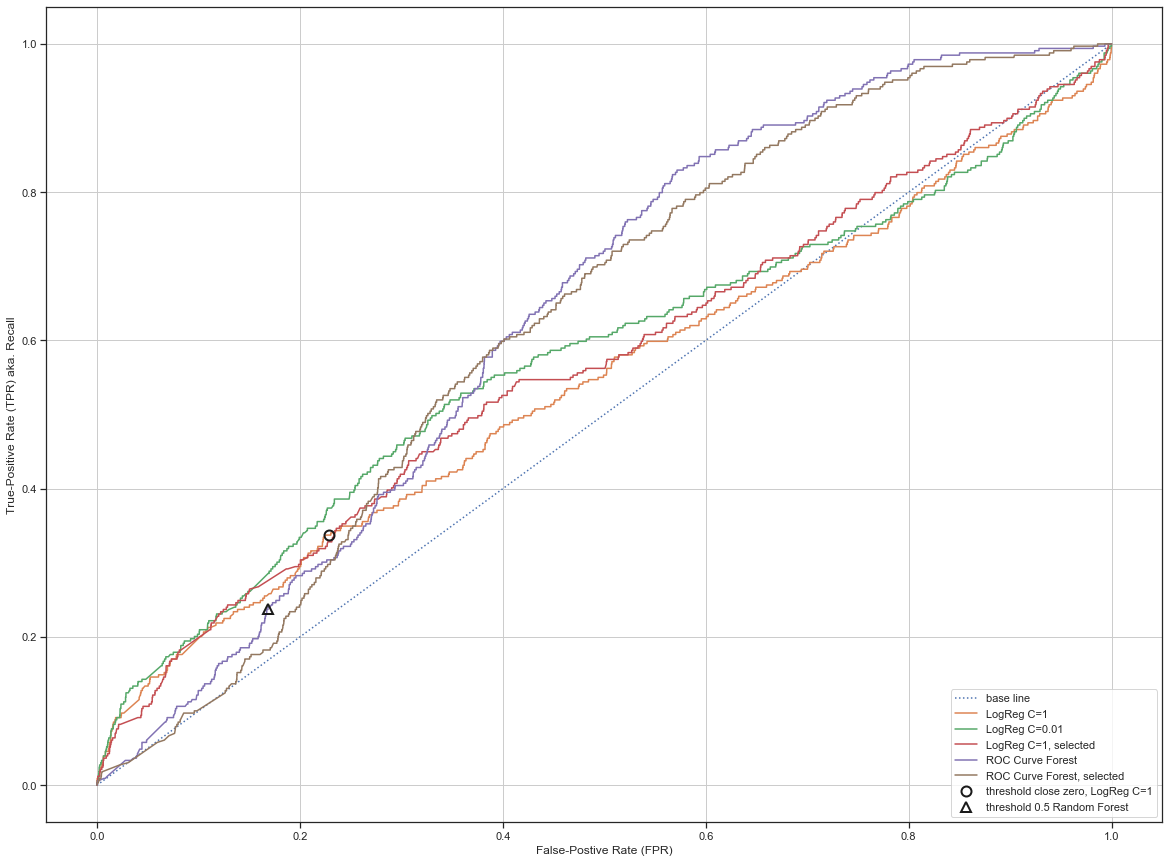

Wall time: 286 ms


In [75]:
%%time
plt.figure(figsize=(20,15))
plt.grid()

plt.plot(fpr_logreg,fpr_logreg, linestyle='dotted', label="base line")

plt.plot(fpr_logreg,      tpr_logreg,      label="LogReg C=1")
#plt.plot(fpr_logreg00001, tpr_logreg00001, label="LogReg C=0.0001")  # bad!
plt.plot(fpr_logreg001,   tpr_logreg001,   label="LogReg C=0.01")
#plt.plot(fpr_logreg100,   tpr_logreg100,   label="LogReg C=100.0")
plt.plot(fpr_logreg_selected, tpr_logreg_selected,  label="LogReg C=1, selected")
plt.plot(fpr_forest,      tpr_forest,      label="ROC Curve Forest")
plt.plot(fpr_forest_selected,tpr_forest_selected,      label="ROC Curve Forest, selected")


plt.xlabel("False-Postive Rate (FPR)")
plt.ylabel("True-Positive Rate (TPR) aka. Recall")

# find threshold closest to zero
close_zero_index = np.argmin(np.abs(thresholds_logreg))
plt.plot(fpr_logreg[close_zero_index], tpr_logreg[close_zero_index],
         'o',
         markersize=10,
         label="threshold close zero, LogReg C=1",
         fillstyle="none",
         c='k',
         mew=2)

close_default_index_forest = np.argmin(np.abs(thresholds_forest - 0.5))
plt.plot(fpr_forest[close_default_index_forest], tpr_forest[close_default_index_forest],
         '^',
         markersize=10,
         label="threshold 0.5 Random Forest",
         fillstyle="none",
         c='k',
         mew=2)

plt.legend(loc=4)
plt.show()

In [76]:
%%time
from sklearn.metrics import roc_auc_score
forest_auc = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
forest_selected_auc = roc_auc_score(y_test, forest_selected.predict_proba(X_test[:,mask])[:, 1])

logreg001_auc = roc_auc_score(y_test, logreg001.decision_function(X_test))
logreg_auc = roc_auc_score(y_test, logreg.decision_function(X_test))
logreg00001_auc = roc_auc_score(y_test, logreg00001.decision_function(X_test))
logreg100_auc = roc_auc_score(y_test, logreg100.decision_function(X_test))
logreg_selected_auc = roc_auc_score(y_test, logreg_selected.decision_function(X_test[:,mask]))

Wall time: 1min 25s


In [77]:
print("AUC for Random Forest:           {:.3f}".format(forest_auc))
print("AUC for Random Forest, selected: {:.3f}".format(forest_selected_auc))
print("AUC for LogReg C=0.001:          {:.3f}".format(logreg001_auc))
print("AUC for LogReg C=0.0001:         {:.3f}".format(logreg00001_auc))
print("AUC for LogReg C=1, selected:    {:.3f}".format(logreg_selected_auc))
print("AUC for LogReg C=1:              {:.3f}".format(logreg_auc))
print("AUC for LogReg C=100:            {:.3f}".format(logreg100_auc))

AUC for Random Forest:           0.634
AUC for Random Forest, selected: 0.623
AUC for LogReg C=0.001:          0.573
AUC for LogReg C=0.0001:         0.566
AUC for LogReg C=1, selected:    0.564
AUC for LogReg C=1:              0.543
AUC for LogReg C=100:            0.535
